In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import itertools

seed = 2718
np.random.seed(seed)

from models import AbstractorOrderRelation, reload_rel_model, rel_model_kwargs

from sklearn.model_selection import train_test_split

2023-04-22 19:06:59.939085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 19:07:00.084527: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 19:07:00.126039: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-22 19:07:00.801449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Relation-Learning: Task 1

In [2]:
# load data
eval_task_data = np.load('object_sorting_datasets/task1_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (eval_task_data['objects'], eval_task_data['seqs'], eval_task_data['sorted_seqs'], eval_task_data['object_seqs'], \
    eval_task_data['target'], eval_task_data['labels'], eval_task_data['start_token'])

In [3]:
num_objects, object_dim = objects.shape
index_pairs = np.array(list(itertools.permutations(range(num_objects), r=2)))
object_order_relations = (index_pairs[:,0] < index_pairs[:, 1]).astype(int)

object_pairs = np.array([objects[index_pair] for index_pair in index_pairs])

In [4]:
sample = np.random.choice(len(object_pairs), 10)
for index_pair, relation in zip(index_pairs[sample], object_order_relations[sample]):
    print(f'object pair: {tuple(index_pair)}; relation: {relation}')

object pair: (54, 42); relation: 0
object pair: (49, 10); relation: 0
object pair: (2, 23); relation: 1
object pair: (24, 5); relation: 0
object pair: (6, 12); relation: 1
object pair: (11, 58); relation: 1
object pair: (31, 45); relation: 1
object pair: (34, 53); relation: 1
object pair: (50, 21); relation: 0
object pair: (56, 22); relation: 0


In [5]:
model = AbstractorOrderRelation(sigmoid_reg_lamda=10., **rel_model_kwargs)
model(object_pairs[:32])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')
model.summary()

2023-04-22 19:07:02.782959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 19:07:03.397665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30975 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


Model: "abstractor_order_rel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  multiple                 2112      
 ibuted)                                                         
                                                                 
 relational_abstracter (Simp  multiple                 54368     
 leAbstractor)                                                   
                                                                 
 dense_1 (Dense)             multiple                  65        
                                                                 
Total params: 56,545
Trainable params: 56,545
Non-trainable params: 0
_________________________________________________________________


2023-04-22 19:07:04.548411: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


In [6]:
model.fit(object_pairs, object_order_relations, epochs=50, batch_size=len(object_pairs), verbose=False)
model.dense.trainable = False
model.fit(object_pairs, object_order_relations, epochs=1000, batch_size=len(object_pairs), verbose=False)

In [7]:
model.evaluate(object_pairs, object_order_relations);

126/126 [==============================] - 0s 1ms/step - loss: 0.2575 - binary_accuracy: 0.9901


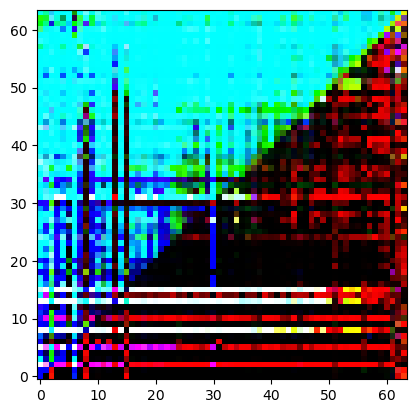

In [8]:
relational_crossattention = model.abstractor.abstracter_layers[0].relational_crossattention.mha

embedded_objects = model.embedder(np.expand_dims(objects, axis=0))

_, attention_scores = relational_crossattention(
    query=embedded_objects, key=embedded_objects, value=embedded_objects, return_attention_scores=True)

rel_img = np.transpose(attention_scores[0])

fig, ax = plt.subplots()
im = ax.imshow(rel_img)
ax.invert_yaxis()

In [9]:
model.save_weights('prelearning_models/task1_rel_model.h5')

In [10]:
# reload model and check it was saved correctly
model = reload_rel_model(weights_path='prelearning_models/task1_rel_model.h5', object_dim=object_dim, kwargs=rel_model_kwargs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')
model.evaluate(object_pairs, object_order_relations);

126/126 [==============================] - 1s 1ms/step - loss: 0.2575 - binary_accuracy: 0.9901


## Relation-Learning: Task 2

In [11]:
# load data
eval_task_data = np.load('object_sorting_datasets/task2_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (eval_task_data['objects'], eval_task_data['seqs'], eval_task_data['sorted_seqs'], eval_task_data['object_seqs'], \
    eval_task_data['target'], eval_task_data['labels'], eval_task_data['start_token'])

In [12]:
num_objects, object_dim = objects.shape
index_pairs = np.array(list(itertools.permutations(range(num_objects), r=2)))
object_order_relations = (index_pairs[:,0] < index_pairs[:, 1]).astype(int)

object_pairs = np.array([objects[index_pair] for index_pair in index_pairs])

In [13]:
sample = np.random.choice(len(object_pairs), 10)
for index_pair, relation in zip(index_pairs[sample], object_order_relations[sample]):
    print(f'object pair: {tuple(index_pair)}; relation: {relation}')

object pair: (2, 4); relation: 1
object pair: (56, 55); relation: 0
object pair: (29, 44); relation: 1
object pair: (39, 46); relation: 1
object pair: (26, 19); relation: 0
object pair: (41, 14); relation: 0
object pair: (37, 14); relation: 0
object pair: (58, 30); relation: 0
object pair: (26, 2); relation: 0
object pair: (41, 60); relation: 1


In [14]:
model = AbstractorOrderRelation(sigmoid_reg_lamda=10., **rel_model_kwargs)
model(object_pairs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')
model.summary()

Model: "abstractor_order_rel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  multiple                 2112      
 tributed)                                                       
                                                                 
 relational_abstracter (Simp  multiple                 54368     
 leAbstractor)                                                   
                                                                 
 dense_9 (Dense)             multiple                  65        
                                                                 
Total params: 56,545
Trainable params: 56,545
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(object_pairs, object_order_relations, epochs=50, batch_size=len(object_pairs), verbose=False)
model.dense.trainable = False
model.fit(object_pairs, object_order_relations, epochs=1000, batch_size=len(object_pairs), verbose=False)

In [16]:
model.evaluate(object_pairs, object_order_relations);

126/126 [==============================] - 0s 1ms/step - loss: 0.2001 - binary_accuracy: 0.9975


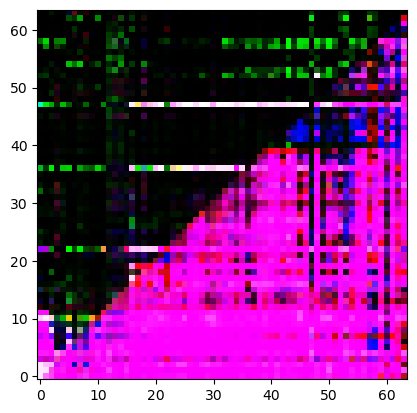

In [17]:
relational_crossattention = model.abstractor.abstracter_layers[0].relational_crossattention.mha

embedded_objects = model.embedder(np.expand_dims(objects, axis=0))

_, attention_scores = relational_crossattention(
    query=embedded_objects, key=embedded_objects, value=embedded_objects, return_attention_scores=True)

rel_img = np.transpose(attention_scores[0])

fig, ax = plt.subplots()
im = ax.imshow(rel_img)
ax.invert_yaxis()

In [18]:
model.save_weights('prelearning_models/task2_rel_model.h5')

In [19]:
# reload model and check it was saved correctly
model = reload_rel_model(weights_path='prelearning_models/task2_rel_model.h5', object_dim=object_dim, kwargs=rel_model_kwargs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics='binary_accuracy')
model.evaluate(object_pairs, object_order_relations);

126/126 [==============================] - 1s 1ms/step - loss: 0.2001 - binary_accuracy: 0.9975


## Argsort-Learning: Task 2
Use 'relation model' to learn arg-sorting on Task 2. This will be used to initialize the argsort model on Task 1.

In [20]:
from models import AutoregressiveSimpleAbstractor, initialize_with_rel_model, decoder_kwargs, reload_argsort_model
from transformer_modules import TeacherForcingAccuracy
from evaluation_utils import evaluate_seq2seq_model

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None, name='sparse_categorical_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

teacher_forcing_acc_metric = TeacherForcingAccuracy(ignore_class=None)
metrics = [teacher_forcing_acc_metric]

In [21]:
# load data
eval_task_data = np.load('object_sorting_datasets/task2_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (eval_task_data['objects'], eval_task_data['seqs'], eval_task_data['sorted_seqs'], eval_task_data['object_seqs'], \
    eval_task_data['target'], eval_task_data['labels'], eval_task_data['start_token'])

num_objects, object_dim = objects.shape

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=test_size, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

seqs_length = seqs.shape[1]

source_train, source_val, source_test = object_seqs_train, object_seqs_val, object_seqs_test


In [22]:
argsort_model_kwargs = dict(embedding_dim=rel_model_kwargs['embedding_dim'], 
    seqs_length=seqs_length, decoder_kwargs=decoder_kwargs)

In [23]:
argsort_model = AutoregressiveSimpleAbstractor(**argsort_model_kwargs)

argsort_model((source_train[:32], target_train[:32]));

rel_model = reload_rel_model(weights_path='prelearning_models/task2_rel_model.h5', object_dim=object_dim, kwargs=rel_model_kwargs)
initialize_with_rel_model(argsort_model, rel_model)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model.summary()

Model: "autoregressive_simple_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  multiple                 2112      
 tributed)                                                       
                                                                 
 relational_abstracter (Simp  multiple                 54880     
 leAbstractor)                                                   
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 decoder (Decoder)           multiple                  274624    
                                  

In [24]:
train_size = 5000
sample_idx = np.random.choice(len(source_train), train_size, replace=False)

X_train = source_train[sample_idx], target_train[sample_idx]
y_train = labels_train[sample_idx]
X_val = source_val, target_val
y_val = labels_val

history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=200, batch_size=256)

Epoch 1/200
20/20 [==============================] - 5s 58ms/step - loss: 2.4095 - teacher_forcing_accuracy: 0.1034 - val_loss: 2.2988 - val_teacher_forcing_accuracy: 0.1138
Epoch 2/200
20/20 [==============================] - 0s 20ms/step - loss: 2.3190 - teacher_forcing_accuracy: 0.1077 - val_loss: 2.2876 - val_teacher_forcing_accuracy: 0.1268
Epoch 3/200
20/20 [==============================] - 0s 20ms/step - loss: 2.2866 - teacher_forcing_accuracy: 0.1230 - val_loss: 2.2209 - val_teacher_forcing_accuracy: 0.1600
Epoch 4/200
20/20 [==============================] - 0s 20ms/step - loss: 2.1634 - teacher_forcing_accuracy: 0.1797 - val_loss: 2.0000 - val_teacher_forcing_accuracy: 0.2341
Epoch 5/200
20/20 [==============================] - 0s 20ms/step - loss: 1.9755 - teacher_forcing_accuracy: 0.2349 - val_loss: 1.8448 - val_teacher_forcing_accuracy: 0.2628
Epoch 6/200
20/20 [==============================] - 0s 20ms/step - loss: 1.8496 - teacher_forcing_accuracy: 0.2594 - val_loss: 1.

In [25]:
# evaluate model on test data
eval_dict = evaluate_seq2seq_model(argsort_model, source_test, target_test, labels_test, start_token, print_=True)

element-wise accuracy: 98.92%
full sequence accuracy: 95.30%
teacher-forcing accuracy:  99.52%


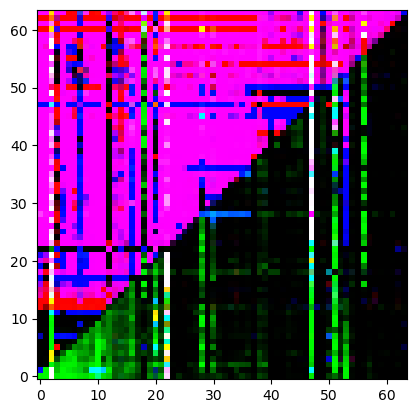

In [26]:
# plot SimpleAbstractor's relations after training (to see how much it changed)
relational_crossattention = argsort_model.abstractor.abstracter_layers[0].relational_crossattention.mha

embedded_objects = argsort_model.source_embedder(np.expand_dims(objects, axis=0))

_, attention_scores = relational_crossattention(
    query=embedded_objects, key=embedded_objects, value=embedded_objects, return_attention_scores=True)

rel_img = np.transpose(attention_scores[0])

fig, ax = plt.subplots()
im = ax.imshow(rel_img)
ax.invert_yaxis()

In [27]:
argsort_model.save_weights('prelearning_models/task2_argsort_model.h5')

In [28]:
# reload model and check it was saved correctly
argsort_model = reload_argsort_model('prelearning_models/task2_argsort_model.h5', object_dim, seqs_length, argsort_model_kwargs)
argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model.evaluate(X_val, y_val);

313/313 [==============================] - 2s 5ms/step - loss: 0.0162 - teacher_forcing_accuracy: 0.9948
